# Analyzing the Analysts: Kaggle Survey and Notebook Submissions Meta-Analysis

## ( Work In Progress )
Authors:
Nataša Vodopivec,
Rok Vodopivec,
Klemen Vodopivec

---

# **Table of contents** <a class='anchor' id='top'></a>

- [Introduction](#introduction)
- [Data Overview](#data_overview)
- [Kaggle Survey Question Analysis](#question_analysis)
- [Competition Notebooks Analysis](#notebooks_analysis)
- [Conclusion](#conclusion)
- [Remarks](#remarks)
- [References](#references)

# **Introduction**<a class='anchor' id='introduction'></a>[↑](#top)

## The data hidden in data.
Kaggle Survey competitions have appeared annually since 2017. Each year numerous competitors submit notebooks wherein they analyse the competition dataset - the respondents’ answers to the survey questions. We decided to do something different. To challenge ourselves, we decided to **inspect the data hidden in data**: to analyse the notebooks of Kagglers which participated in past Kaggle Survey competitions, as well as they survey questions themselves.

Our analysis is split into two main topics of focus:

    i) Kaggle Survey question analysis: Are the trends present in the data science community reflected by the questions from the survey?

    ii) Competition notebooks analysis: Can we observe any trends in submitted notebooks like programming language used and Kaggle tiers of participants? Which themes were the competition participants most often interested in? Which libraries did they use in their notebooks? How is notebook success best measured? Does it depend on the experience of participants?
    
Continue reading to find the answers to all these questions.. and more.

---

# **Data overview**<a class='anchor' id='data_overview'></a>[↑](#top)

## Data Acquisition<a class='anchor' id='data_acquisition'></a>[↑](#data_overview)

The nature of the work we have decided to undertake required us to generate our own datasets. We created more, as we cover two distinct topics and different datasets help us answer different questions. It was one of the main efforts of our project as well as a fun challenge. This section gives an overview of the work involved.

The list of our datasets and their short descriptions are given [below](#data_datasets).
However, here we want to describe how data for our biggest dataset, [all_kernels.csv](#all_kernels) was acquired, as it took most of our efforts to prepare and we'd like for it to be useful for other Kagglers too!👩🏻‍💻

To get the data we wrote the **ETL** (*extract-transform-load*) scraping code in Python. The code is publicly accessible in our [GitHub repository](https://github.com/moratsam/kaggle-survey-2022) and we kindly invite you to play around with it. **# TODO make public.**

<div style="padding:20px; 
            margin:10px;
            font-size:110%;
            display: fill;
            border-radius:10px;
            border-style: solid;
            border-color: #54b4c4;
            background-color:#54b4c4;
            overflow:hidden;
            font-weight:500">
Our kernels dataset consists of compiled data of every kernel that participated in any Kaggle Survey Competition since 2017, when the annual survey began.
</div>

There are many! 🎉 The data structure of our kernel dataset looks like this:

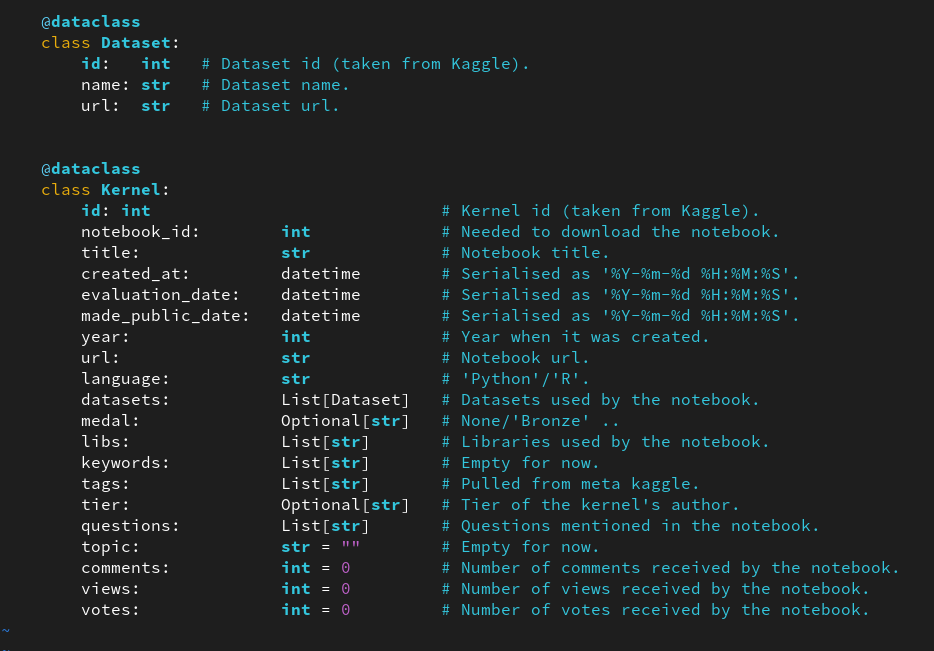


Data for most of these fields is taken directly from scraping *Kaggle.com*. The ***Code*** section of a Kaggle competition or dataset page shows the notebooks which competed in this competition or used this dataset. Looking closely, we discovered that notebooks get loaded via ***POST requests*** made to an internal [Kaggle API](https://www.kaggle.com/api/i/kernels.KernelsService/ListKernels). So convenient! We made use of it and to obtain the kernel data, we programatically intercepted this traffic and parsed it.

To make our dataset even more informative, we added the fields ***created_at***, ***evaluation_data***, ***made_public_date***, ***year***, ***tags*** and ***tier***. These were taken from the official [Meta Kaggle dataset](https://www.kaggle.com/datasets/kaggle/meta-kaggle).

Additionally, fields ***libs***, which is a list of libraries imported by a notebook, and ***questions***, which is a list of questions addressed by a notebook, were populated by parsing each kernel's raw notebook.



## Our Datasets <a class='anchor' id='data_datasets'></a>[↑](#data_overview)

All in all, in the years 2017-2022 **1822** kernels used the Kaggle Survey datasets.
We have ordered our data into several distinct datasets, each of which was useful in obtaining answers to our questions on at least one of the topics. The obtained datasets are briefly overviewed below.

   
* **notebooks.zip**

   Contains **1822** raw notebooks saved as either `ipynb` or `Rmd`. 58 notebooks could not be executed neither in Python nor in R, so they were given the extension `unknown_format.txt`. The name of each file is the `notebook_id` as listed on `kaggle.com` and matches `notebook_id` in the file `all_kernels.csv`, which is described below. Among other things, this dataset was used to obtain a per-notebook list of imported libraries, as well as the questions that were addressed by each notebook.
   

* **all_kernels.csv**<a class='anchor' id='all_kernels'></a>

   Each row of this dataset contains data about one of the **1822** kernels. The columns correspond  to all the fields listed in the *Kernel* class image above. A more detailed overview of the columns can be found on the [dataset's Kaggle page](https://www.kaggle.com/datasets/jakkajdsfs/kaggle-survey-historical-meta).
   
   
* **cleaned_kernels.csv**

    This is in effect the main dataset we used in our competition notebook. We took ***all_kernels.csv*** and removed from it 233 rows which described kernels which were just unchanged forks of other kernels.


* **all_questions.json**
   
   Contains all Kaggle Survey questions from the years 2017-2022. In the year 2017, the survey questions were unnumbered, so we numbered them ourselves, keeping the original order and using zero-based indexing. Surveys 2018-2022 have numbered questions, so the index was taken unchanged.


* **question_map.csv**
   
   Looking at survey questions over several years, one can note that certain questions repeat. For example, every year's survey contains a question `What is your age`. All such repetitions are captured in this dataset. For each unique question, the question number and the survey year where this question appears is given. The question numbers are described in the preceding paragraph `sorted_questions_all.json`. Certain questions are worded differently but functionally identical. If such questions were joined, a note was added, to alert other users of this dataset.

---

# Kaggle Survey Question Analysis<a class='anchor' id='question_analysis'></a>[↑](#top)

We have noticed, that some of the questions on the Kaggle Survey change by the year. We wanted to dig deeper and find out how this relates to the trends of data science. Analysis of Kaggle Survey questions was the first of the topics we chose to research.

Data science is a fast-evolving field. New technologies are emerging all the time, replacing older ones in the process. We wanted to explore if this is reflected in the questions posed by the survey throughout the years.

<div style="padding:20px; 
            margin:10px;
            font-size:110%;
            display: fill;
            border-radius:10px;
            border-style: solid;
            border-color: #54b4c4;
            background-color:#54b4c4;
            overflow:hidden;
            font-weight:500">We analyzed trends in <b>Cloud Technologies</b>, <b>Specialized Hardware</b> and <b>Machine Learning Frameworks</b>
    </div>

In [15]:
import json
import os
import string
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud

git = False

# palettes
global_palette = ['#32BDD3', '#AC3931', '#273C2C', '#C6940F', '#D3C1D2', '#9E53A8']
# terminal colors #54b4c4 #603060

global_color = global_palette[5]
global_color_light = '#a5a3bd'
global_edge_color = 'black'
sns.set_palette(global_palette)
medals_palette = ['#C0C0C0', '#967444', 'black', 'gold']


### Number of Questions containing the word 'Cloud'
With the increase in the number and quantity of data,the need for new technologies and ways of processing and analyzing it has arose *[1]*. Cloud Computing has emerged as one of the most popular solutions to this problem. We wanted to explore how the mention of **Cloud Technologies** in the survey changed throughout the years. Counting every year's questions which contain the word `Cloud`, we arrive at the following result.

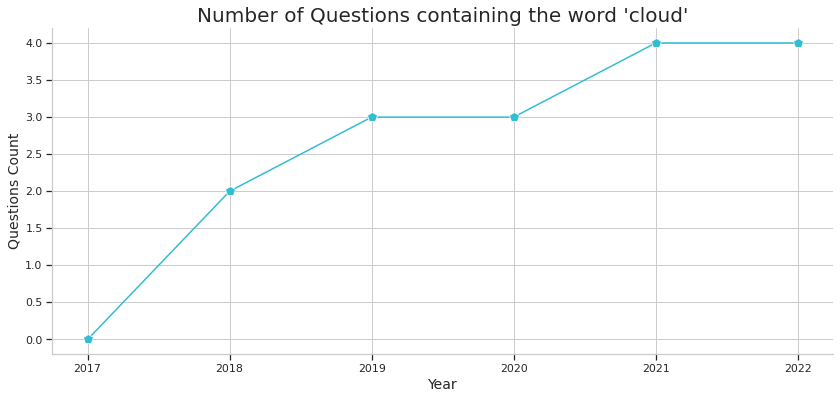

In [16]:
if git:
    with open('kaggle-survey-historical-meta/all_questions.json') as f:
        all_qs = json.load(f)
else:
    with open('../input/d/jakkajdsfs/kaggle-survey-historical-meta/all_questions.json') as f: # Wat dis
#     with open('/kaggle/input/kaggle-survey-historical-meta/all_questions.json') as f:
  
        all_qs = json.load(f)

cloud_cnts = {year: 0 for year in range(2017, 2023)}
for year in all_qs:
    for question in all_qs[year].values():
         if 'cloud' in question:
             cloud_cnts[int(year)] += 1

cloud_series = pd.Series(cloud_cnts)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", palette=global_palette, rc=custom_params)
plt.figure(figsize=(14,6))


# sns.lineplot(x=cloud_series.index, y=cloud_series, marker='p',markersize= 10, color='red')
sns.lineplot(x=cloud_series.index, y=cloud_series, marker='p',markersize= 10)
plt.title("Number of Questions containing the word 'cloud'",fontsize=20)
plt.xlabel('Year', fontsize=14);
plt.ylabel('Questions Count', fontsize=14)
plt.tick_params(bottom=True, left=True)

plt.show()

We can see the number of questions referring to **Cloud Technology** is **growing** throughout the years. This comes as no surprise as more and more companies are using the Cloud for storing, processing and analyzing Big Data. We can probably expect further growth in questions referring to Cloud Technologies in future surveys.

### Answer choices to question 'Which types of specialized hardware do you use on a regular basis?' by Year
In recent years we have seen the emergence of dedicated **AI accelerator hardware** *[2]*. Companies such as Google, Qualcomm, Amazon, Apple, Facebook, AMD and Samsung are all designing their own specialized hardware. Cerebras Systems has also built a dedicated AI accelerator based on the largest processor in the industry, the second-generation Wafer Scale Engine (WSE-2), to support deep learning workloads. Plotting the choices given by the surveys in answer to the question`Which types of specialized hardware do you use on a regular basis?` *(1)*, we obtain the following heatmap:

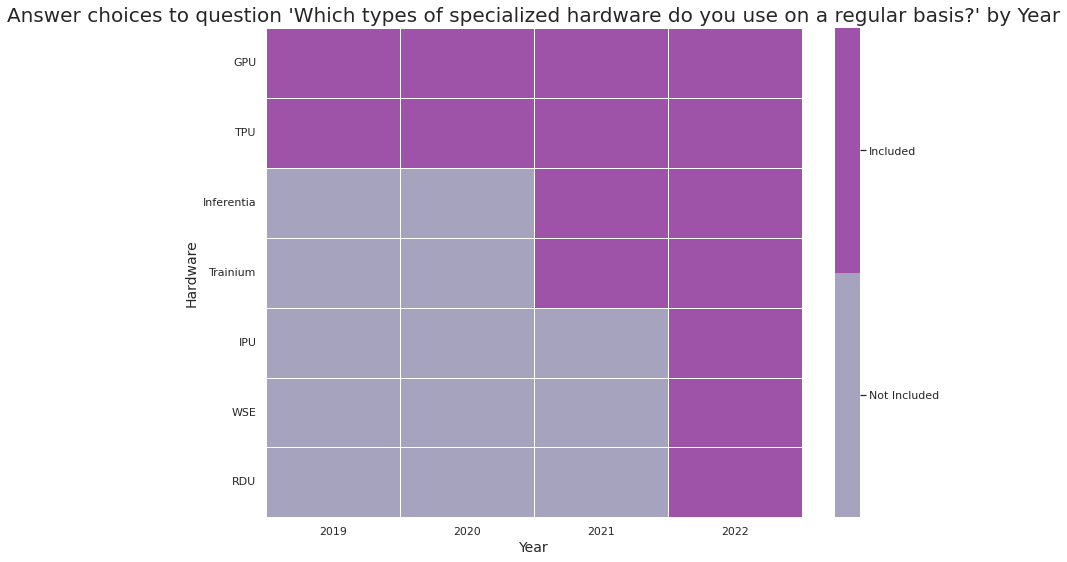

In [17]:
hardware = pd.read_csv('/kaggle/input/question-analysis/hardware.csv')
#hardware = pd.read_csv('question-analysis/hardware.csv')

hardware = hardware.set_index('Hardware')

plt.figure(figsize=(12,9))

ax = sns.heatmap(
    hardware, 
    annot=False,
    cmap=[global_color_light, global_color],
    linewidth=.5)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Not Included', 'Included'])
plt.title("Answer choices to question 'Which types of specialized hardware do you use on a regular basis?' by Year",fontsize=20)
plt.xlabel('Year', fontsize=14);
plt.ylabel('Hardware', fontsize=14)
plt.yticks(rotation=0)

plt.show()


The emergence of new specialized hardware can clearly be seen in the above graph. In 2021 Amazon's **Inferentia** and **Trainium** appeared as answer choices. In year 2022 Graphcore's **IPU**, Cerebras' **RSE** and SambaNova's **RDU** also appeared. We expect there will be even more options to chose from in the future, as more specialized hardware apperas on the market.

### Answer choices to question 'Which machine learning frameworks do you use on a regular basis?' by Year
While the number of Machine Learning algorithms is extensive and growing, their implementations through frameworks and libraries is also extensive and growing too *[3]*. The software development in this field is fast paced with a large number of open-source software coming from the academy, industry, start-ups or wider open-source communities. Plotting the choices given by the surveys when asking about the `Usage of machine learning frameworks` *(2)*, we arrive at the following heatmap:

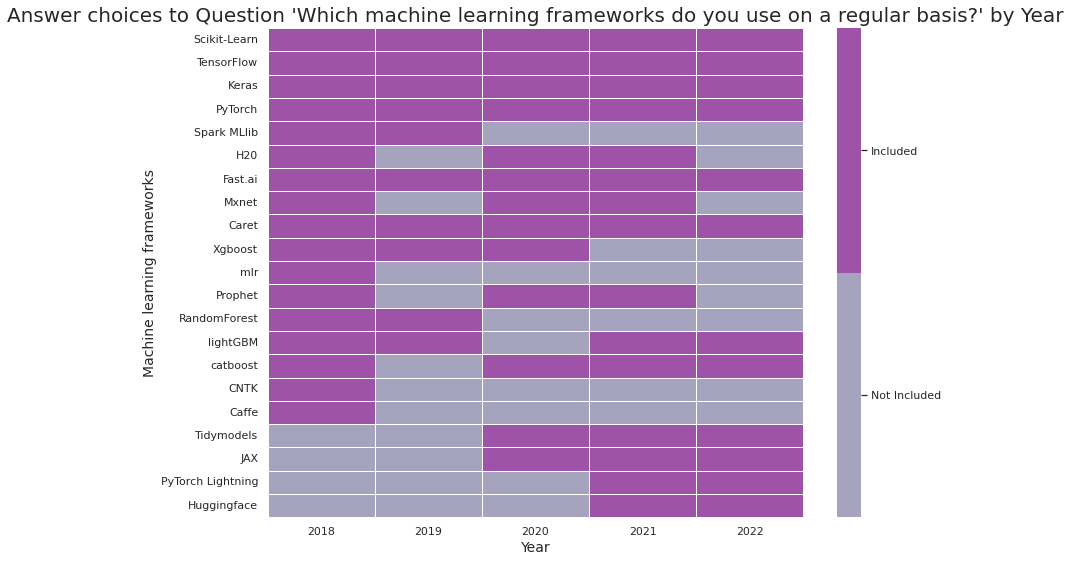

In [18]:
ml_frameworks = pd.read_csv('/kaggle/input/question-analysis/ml_frameworks.csv')
#ml_frameworks = pd.read_csv('question-analysis/ml_frameworks.csv')
ml_frameworks = ml_frameworks.set_index('Framework')
plt.figure(figsize=(12,9))
frameworks_plot = sns.heatmap(
                        ml_frameworks, 
                        annot=False,
                        cmap=[global_color_light, global_color],
                        linewidth=.5)
colorbar = frameworks_plot.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Not Included', 'Included'])
plt.title("Answer choices to Question 'Which machine learning frameworks do you use on a regular basis?' by Year",fontsize=20)
plt.xlabel('Year', fontsize=14);
plt.ylabel('Machine learning frameworks', fontsize=14)

plt.show()

The dynamics of ML framework usage can be seen in the above graph. We observe the emergence of new ML frameworks, most recently **PyTorch lightning** and **Huggingface**. Others, namely as **RandomForest**, **lightGBM** and **sparkMLlib** have dissappeared from the answer choices. Meanwhile some of the most popular ones, such as **Scikit-learn**, **Tensorflow**,**keras** and **PyTorch** endure throughout the years. We can only imagine how these dynamics play-out in the future!

---

# Competition Notebooks Analysis<a class='anchor' id='notebooks_analysis'></a>[↑](#top)

Analysis of Kaggle Survey questions already gave us a lot of interesting insights. In our quest of meta analysis, the analysis of past competition notebooks was the second the topic we chose to research.

We did the competition notebook analysis in three parts:
1. Trends #TODO each explain briefly
2. Text
3. Notebook Success

There have been many excellent notebook submissions in the Kaggle Survey competitions. Let's see what we can learn from them.

In [19]:
# cleaned_kernels_df = pd.read_csv('/kaggle/input/kaggle-survey-historical-meta/cleaned_kernels.csv')
if git:
    cleaned_kernels_df = pd.read_csv('kaggle-survey-historical-meta/cleaned_kernels.csv')
else:
    cleaned_kernels_df = pd.read_csv('/kaggle/input/d/jakkajdsfs/kaggle-survey-historical-meta/cleaned_kernels.csv') # Wat dis
#     cleaned_kernels_df = pd.read_csv('/kaggle/input/kaggle-survey-historical-meta/cleaned_kernels.csv')

## 1) Trends

### Number of Notebook Submissions per Year
Below we show the number of notebook submissions per year, from 2017 to 2021.

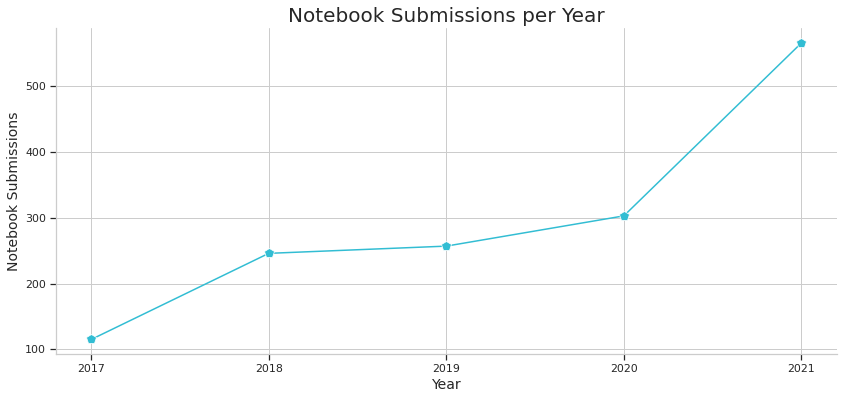

In [20]:
# remove rows where year is 1970 or 2022.
without_null_df = cleaned_kernels_df.loc[~cleaned_kernels_df['year'].isin([1970, 2022])]

# create a count dataframe
submissions_df = without_null_df.year.value_counts().rename('submissions_count').reset_index()

# draw a lineplot
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", palette=global_palette, rc=custom_params)
plt.figure(figsize=(14,6))

submissions_plot = sns.lineplot(data=submissions_df,
                                 x="index",
                                 y='submissions_count',
                                 marker='p',
                                 markersize=10)
submissions_plot.set_xticks(range(2017, 2022), labels=range(2017, 2022))
plt.title('Notebook Submissions per Year',fontsize=20)
plt.xlabel('Year', fontsize=14);
plt.ylabel('Notebook Submissions', fontsize=14)
plt.tick_params(bottom=True, left=True)

plt.show()

The Kaggle survey competitions seems to be growing in popularity, as notebook submissions increase every year (the data for 2022 is incomplete, we will see if that still holds). There is an especially big jump in year 2021, where notebook submissions grew by more than 100%.

### Programming Language used per Year
In the plot below we show how the choice of programming language changed throughout the years.

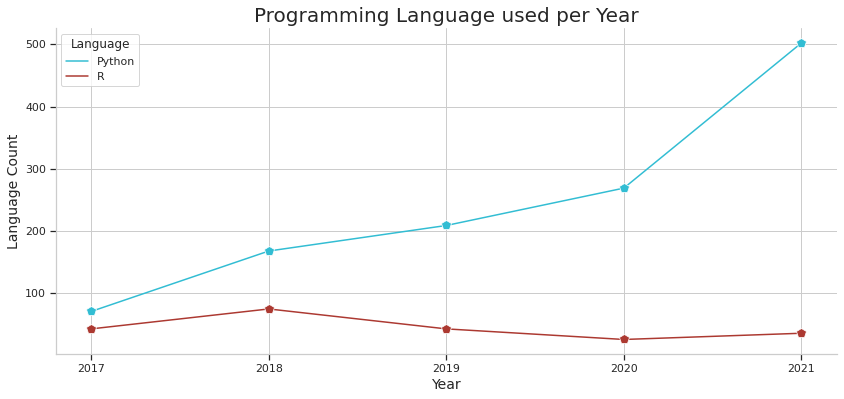

In [21]:
without_unknown_language_df = without_null_df.loc[without_null_df['language'] != 'UNKNOWN']
languages_df = without_unknown_language_df.groupby('year').language.value_counts().rename("language_count").reset_index()

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", palette=global_palette, rc=custom_params)
plt.figure(figsize=(14,6))

languages_plot = sns.lineplot(data=languages_df,
                         x='year',
                         y='language_count',
                         hue = 'language',
                         marker="p",
                         markersize=10)
languages_plot.set_xticks(range(2017, 2022), labels=range(2017, 2022))
plt.title('Programming Language used per Year', fontsize=20)
plt.xlabel('Year', fontsize=14);
plt.ylabel('Language Count', fontsize=14)
plt.tick_params(bottom=True, left=True)
plt.legend(loc='upper left', title='Language')

plt.show()

Python usage is growing, while R usage is declining. In 2017 python was used in 62.3% of submissions, while 47.7% used R. In 2021 python was used in 93.3% of submissions while only 6,7% used R. These resuts coincide with the observations that python is becoming the go-to programming language for data science and one of the most popular languages overall *[xx]*.

### Kaggle Tiers by Year
In this plot we explore how Kaggle tiers of participants changed throughout the years.

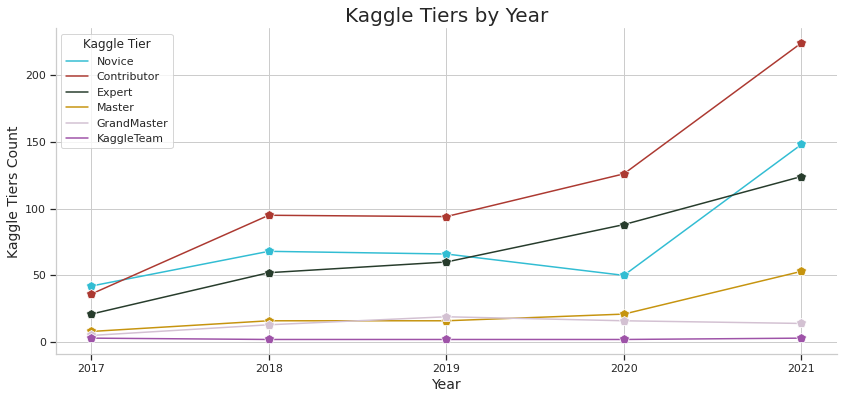

In [22]:
tiers_df = without_null_df.groupby('year').tier.value_counts().rename("tier_count").reset_index()

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", palette=global_palette, rc=custom_params)
plt.figure(figsize=(14,6))

tiers_plot = sns.lineplot(data=tiers_df,
                         x='year',
                         y='tier_count',
                         hue = 'tier',
                         marker="p",
                         markersize=10)
tiers_plot.set_xticks(range(2017, 2022), labels=range(2017, 2022))
plt.title('Kaggle Tiers by Year', fontsize=20)
plt.xlabel('Year', fontsize=14);
plt.ylabel('Kaggle Tiers Count', fontsize=14)
plt.tick_params(bottom=True, left=True)
plt.legend(loc='upper left', title='Kaggle Tier')

plt.show()

In the first survey challenge novices were the most frequent tier. The were soon overtaken by contributors as the tier of most participants. Experts seem to also take more interest in this challenge, as their group continues to grow.

---

## 2) Text 

### Popular Libraries used by participants
In this plot we examine which are the most popular libraries used by participants in their notebooks.

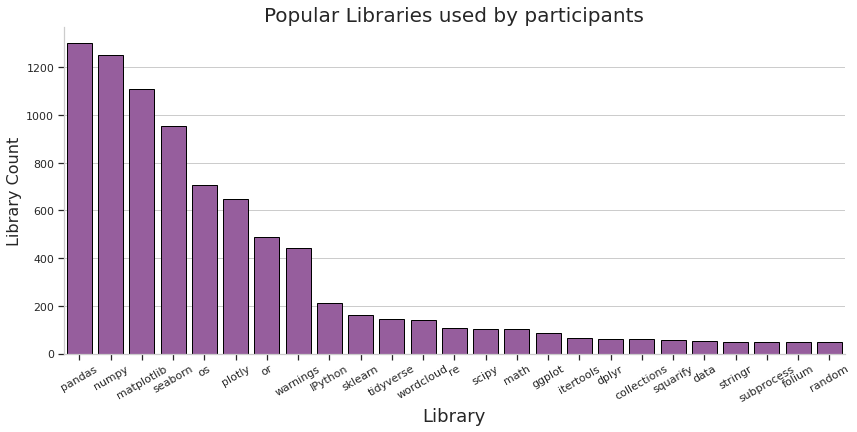

In [23]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
libs_arr = []
for index, row in cleaned_kernels_df.iterrows():
        libs_arr.append(row['libs'])
        
libs = ' '.join(libs_arr).translate(str.maketrans('', '', string.punctuation)).split()
libs_count = Counter(libs)

libs_df = pd.DataFrame(libs_count.items(), columns = ['Library', 'Library Count'])
libs_df = libs_df.sort_values(by=['Library Count'], ascending = False).head(25)


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(14,6))

libs_plot = sns.barplot(data=libs_df, 
                        x='Library',
                        y='Library Count',
                        edgecolor=global_edge_color,
                        color=global_color)
plt.xticks(rotation=30)
plt.title('Popular Libraries used by participants',fontsize=20)
plt.xlabel('Library', fontsize=18);
plt.ylabel('Library Count', fontsize=16)
plt.tick_params(bottom=True, left=True)

plt.show()

- The five most popular libraries are ***pandas*** (used 1303 times) ***numpy*** (used 1252 times), ***matplotlib*** (used 1108 times), ***seaborn*** (used 956 times) and ***os*** (used 706 times), which are all ***Python*** libraries.
- The most popular ***R*** libraries are ***tidyverse*** (used 143 times), ***ggplot*** (used 84 times) and ***dplyr*** (used 62 times).

### Kernel Titles Wordcloud
The wordcloud below shows the most frequently used words in the titles of notebook submissions.

In [24]:
title_corpus = ' '.join(cleaned_kernels_df['title']).lower()

# mask image modified from: https://previews.123rf.com/images/pavlematic/pavlematic2003/pavlematic200300025/142390318-black-brain-silhouette-isolated-on-white-background.jpg
if git:
    mask = np.array(Image.open('brain.png'))
else:
    mask = np.array(Image.open('/kaggle/input/brainmask/brain.png'))

ignorewords = ['kaggler', 'kaggle', 'data', 'scientist', 'survey', 'science', 'analysis', 'story', 'machine', 'learning', 'challenge', 'eda', 'results']
for common in ignorewords:
    title_corpus = title_corpus.replace(common, "")

cmap = ListedColormap(global_palette, name="cmap")
title_wordcloud = WordCloud(background_color='#fff',colormap=cmap, mask=mask, height=1000, width=2000,min_word_length=3).generate(title_corpus)
plt.figure(figsize=(12,12))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/brainmask/brain.png'

The wordcloud shows that some of the more frequently analyzed topics include country (especially india), gender, jobs, salary and tools.

### Popular Tags used by participants
In the next plot we examine which are the most popular tags used by participants.

In [ ]:
tags_arr = []
for index, row in cleaned_kernels_df.iterrows():
        tags_arr.append(row['tags'])
        
tags = ' '.join(tags_arr).translate(str.maketrans('', '', string.punctuation)).split()
tags_count = Counter(tags)

tags_df = pd.DataFrame(tags_count.items(), columns = ['Tag', 'Tag Count'])
tags_df = tags_df.sort_values(by=['Tag Count'], ascending = False).head(25)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(14,6))

tags_plot = sns.barplot(data=tags_df, 
                        x='Tag',
                        y='Tag Count', 
                        edgecolor=global_edge_color,
                       color=global_color)
plt.xticks(rotation=30)
plt.title('Popular Tags used by participants',fontsize=20)
plt.xlabel('Tag', fontsize=14);
plt.ylabel('Tag Count', fontsize=14)
plt.tick_params(bottom=True, left=True)

plt.show()

- The five most popular tags are ***data*** (used 1161 times), ***analysis*** (used 729 times), ***visualization*** (used 520 times), ***exploratory*** (used 410 times) and ***survey*** (used 301 times). We can see they are all related to the theme of the competition.

- More telling are the tags not directly related to competition theme or language used. Of those, the top five are ***beginner*** (used 204 times), ***business*** (used 69 times), ***cleaning*** (used 65 times), ***education*** (used 62 times) and ***programming*** (used 36 times).

---

## 3) Notebook Success

### Correlation between Success Parameters
There are a few parameters with which one can measure the success of a notebook. They are the number of votes, comments and views a notebook gets, and also the type of medal it was awarded (if it got one). These parameters are probably correlated, and below we explore what this correlation looks like.

In [ ]:
success_df = cleaned_kernels_df[["medal","comments","views",'votes']]
success_df = success_df.replace(np.nan, 'NO MEDAL')

success_plot = sns.PairGrid(data=success_df,
                            hue = 'medal',
                            palette= ['black', '#967444', '#C0C0C0', 'gold'])
success_plot.map(plt.scatter)
success_plot.add_legend(loc='center right', title='Medals', label_order=['NO MEDAL', 'BRONZE', 'SILVER', 'GOLD'])
success_plot.fig.set_size_inches(12,8)
success_plot.fig.subplots_adjust(top=0.91)
success_plot.fig.suptitle('Correlation between Success Parameters',fontsize=20)

plt.show()

- Views vs Votes: Notebooks with more views seem to also get more votes, although there are also cases of notebooks with lots of views and not many votes. Most of the highest viewed notebooks also have a medal. 
- Views vs Comments: Notebooks with more views tedn to get more comments. But there also exist notebooks with lots of comments and fewer views and vice-versa. The notebooks with most views and comments combined also recieved a gold medal.
- Votes vs Comments: Notebooks with more votes also get more comments. The notebooks with most votes and comments combined also recieved a gold medal.

### Medals won by Kaggle Tier
In this graph we explore the correlation between Kaggle tiers and medals won. As some tiers are bigger than others, we don't show the absolute medal counts by each tier. Instead we show the data as what percentage of Kagglers in each tier won a medal.

In [ ]:
tiers_medals_df = without_null_df[['tier','medal']]

tiers_medals_df = tiers_medals_df.groupby('tier').medal.value_counts().rename('medalCount').reset_index()

tiers_count = without_null_df.tier.value_counts()
contrubutor_all = tiers_count[0]
novice_all = tiers_count[1]
expert_all = tiers_count[2]
master_all = tiers_count[3]
gm_all = tiers_count[4]
team_all = tiers_count[5]


tiers_medals_df['medalCount'] = np.where(tiers_medals_df.tier == 'Contributor',100*tiers_medals_df.medalCount/contrubutor_all, tiers_medals_df.medalCount)
tiers_medals_df['medalCount'] = np.where(tiers_medals_df.tier == 'Novice',100*tiers_medals_df.medalCount/novice_all , tiers_medals_df.medalCount)
tiers_medals_df['medalCount'] = np.where(tiers_medals_df.tier == 'Expert',100*tiers_medals_df.medalCount/expert_all, tiers_medals_df.medalCount)
tiers_medals_df['medalCount'] = np.where(tiers_medals_df.tier == 'Master',100*tiers_medals_df.medalCount/master_all, tiers_medals_df.medalCount)
tiers_medals_df['medalCount'] = np.where(tiers_medals_df.tier == 'GrandMaster',100*tiers_medals_df.medalCount/gm_all, tiers_medals_df.medalCount)
tiers_medals_df['medalCount'] = np.where(tiers_medals_df.tier == 'KaggleTeam',100*tiers_medals_df.medalCount/team_all, tiers_medals_df.medalCount)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(14,6))

tiers_medals_plot = sns.barplot(data=tiers_medals_df,
                                x='tier', 
                                y='medalCount',
                                hue='medal',
                                order=['Novice', 'Contributor', 'Expert', 'Master', 'GrandMaster', 'KaggleTeam'],
                                edgecolor='black', 
                                palette= ['#967444', '#C0C0C0', 'gold'])                
plt.title('Medal won percentage by Kaggle tier',fontsize=20)
plt.xlabel('Kaggle Tier', fontsize=14);
plt.ylabel('Medal won percentagee', fontsize=14)
plt.tick_params(bottom=True, left=True)
plt.legend(loc='upper left', title='Medals')

plt.show()

As can be seen in the graph, the more experienced a Kaggler is, the more chance he has to get a medal. Novices seem to have it out for themselves, as only 17% managed to grab a medal (mostly bronze, no gold). GrandMasters show us why they deserve that title, as 43%% of their submissions were awarded the gold medal. Teaming up seems to help as well, as almost all of KaggleTeams managed to grab at least a bronze medal.

### Average Vote by Kaggle Tier
Here we explore how the number of upvotes is correlated to Kaggle tiers.

In [ ]:
tiers_votes_df = without_null_df[['tier','votes']]

tiers_votes_mean_df = tiers_votes_df.groupby('tier').agg('mean')

tiers_votes_mean_df.reset_index(inplace=True)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(14,6))

tiers_votes_plot = sns.barplot(data=tiers_votes_mean_df,
                               x='tier',
                               y='votes',
                               order=['Novice', 'Contributor', 'Expert', 'Master', 'GrandMaster', 'KaggleTeam'],
                               edgecolor=global_edge_color,
                               color=global_color)
plt.title('Average Vote by Kaggle tier',fontsize=20)
plt.xlabel('Kaggle Tier', fontsize=14);
plt.ylabel('Average Vote', fontsize=14)
plt.tick_params(bottom=True, left=True)

plt.show()

We see that the more experienced a Kaggler is, the higher is his average vote. Novices again fare the worst, with only 3.7 average votes. Contributors follow with 8.6 average votes, then KaggleTeams with 13.1, Experts with 19.5 and Masters with 35. GrandMasters exceed all with 77.2 votes on average.

---

# **Conclusion**<a class='anchor' id='conclusion'></a>[↑](#top)

---

# Remarks<a class='anchor' id='remarks'></a>[↑](#top)
[1] *The questions are Q21, Q12, Q12, Q42, respectively.*

[2] *The questions are Q19, Q28, Q16, Q16, Q17, respectively.*

---

# References<a class='anchor' id='references'></a>[↑](#top)
* [1] https://journalofcloudcomputing.springeropen.com/articles/10.1186/s13677-022-00301-w#Sec10
* [2] https://en.wikipedia.org/wiki/AI_accelerator
* [3] https://link.springer.com/article/10.1007/s10462-018-09679-z
* [xx] https://www.tiobe.com/tiobe-index/python/